In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

### Load CSV and plot 'Adj Close'

<IPython.core.display.Javascript object>


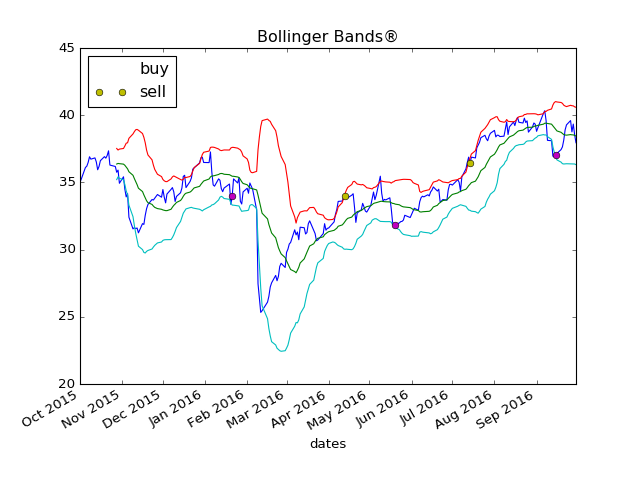

In [2]:
dates = pd.date_range('2015-10-01', '2016-09-30')
df = pd.DataFrame(index=dates)
hcp = pd.read_csv('hcp.csv', index_col='Date', parse_dates=True, usecols=['Date', 'Adj Close'])
df = df.join(hcp)
df = df.dropna(subset=["Adj Close"])
df['dates'] = df.index
ax = df['Adj Close'].plot(label='Adj Close', title="Bollinger Bands"+u"\u00AE")

ax

### Calculate and plot rolling mean

In [3]:
df['rolling_mean'] = df['Adj Close'].rolling(center=False, window=20).mean()
df['rolling_mean'].plot(label='Rolling Mean', ax=ax)

ax

### Calculate and plot rolling bounds

In [4]:
df['rolling_std'] = df['Adj Close'].rolling(center=False, window=20).std()
df['upper_band'] = df['rolling_mean'] + 2*df['rolling_std']
df['lower_band'] = df['rolling_mean'] - 2*df['rolling_std']

df['upper_band'].plot(label='upper bound', ax=ax)
df['lower_band'].plot(label='lower bound', ax=ax)

ax

### Find intersection of 'Adj Close' and rolling values

In [5]:
# find intersections of Adj Close with rolling mean
df['CloseXrm'] = df.loc[(df['rolling_mean'] > df['Adj Close']) & (df['rolling_mean'].shift(1) < df['Adj Close'].shift(1))]['Adj Close']

# get all down intersections of lower band
df['down_lower'] = df.loc[(df['lower_band'] < df['Adj Close']) & (df['lower_band'].shift(1) > df['Adj Close'].shift(1))]['Adj Close']

#get all up intersections of upper band
df['up_upper'] = df.loc[(df['upper_band'] > df['Adj Close']) & (df['upper_band'].shift(1) < df['Adj Close'].shift(1))]['Adj Close']


### Setting marks to get buy and sell points

In [6]:
#mark CloseXrm with buy and sell points
df.loc[df['down_lower'] > 0, 'mark'] = -1
df.loc[df['up_upper'] > 0, 'mark'] = -2
df['CloseXrm'] = df['CloseXrm'].fillna(method='ffill')

buy_points = df.loc[(df['mark'] == -1)].groupby('CloseXrm').first()['dates'].values

df.loc[df.index.isin(buy_points), 'buy'] = True
df['buy'] = df['buy'].fillna(False)

df.loc[(df['buy'] == True), 'mark'] = 1
df['mark'] = df['mark'].fillna(method='ffill')

df.loc[(df['mark'] == -2) & (df['mark'].shift(1) == 1), 'sell'] = True
df['buy'] = df['buy'].fillna(False)

df.loc[(df['buy'] == True) & (df['mark'].shift(1) == 1), 'buy'] = False

# plot points to buy
df.loc[(df['buy'] == True)].plot(x='dates', y='Adj Close', label="buy", style='o', ax=ax)

# plot points to sell
df.loc[(df['sell'] == True)].plot(x='dates', y='Adj Close', label="sell", style='o', ax=ax)

plt.show()

### Possible amount of win

In [7]:
df_c = df.loc[df['sell']==True].join(df.loc[df['buy']==True], how='outer', lsuffix='_l', rsuffix='_r')
#print df_c
# df_c['Adj Close comb'] = df_c['Adj Close_l'].fillna(0)+df_c['Adj Close_r'].fillna(0)
amount_per_share = (df_c['Adj Close_l'] - df_c['Adj Close_r'].shift(1)).fillna(0).sum()
print 'Amount of win per share:', amount_per_share 


Amount of win per share: 4.570442
